## Import packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib

## Data preparation

In [13]:
real_df = pd.read_table('/projects/genomic-ml/da2343/ml_project_2/robust_algo_trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# real_df = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_202302010000_202304242100.tsv')

df = real_df.copy()
# take only last 7000 rows
# df = df.iloc[-(200+24*7*4):]
# take only first 7000 rows
# df = df.iloc[:7000]
# from 7000 to 14000
df = df.iloc[7_000:8_000]

# df = df.iloc[-(24*7*3):]
# df = df.iloc[-(24*5):]
# df = df.iloc[-120:]
# remove the following columns <TICKVOL>, <VOL> and <SPREAD>
df = df.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
df = df.rename(columns={'<DATE>': 'Date', 
                                '<TIME>': 'Time', 
                                '<OPEN>': 'Open', 
                                '<HIGH>': 'High', 
                                '<LOW>': 'Low', 
                                '<CLOSE>': 'Close'
                                })
# combine the date and time columns
df['Date_Time'] = df['Date'] + ' ' + df['Time']
# remove the date and time columns
df = df.drop(['Date', 'Time'], axis=1)
# convert the date_time column to datetime
df['Time'] = pd.to_datetime(df['Date_Time'])
# Rename Date_Time to Time
# df.index = df['Time']
# df.set_index("Time")
# remove the Time column
df = df.drop(['Time'], axis=1)

prices = df["Close"].values
df["SMA"] = talib.SMA(prices, timeperiod=200)
df = df.dropna()

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

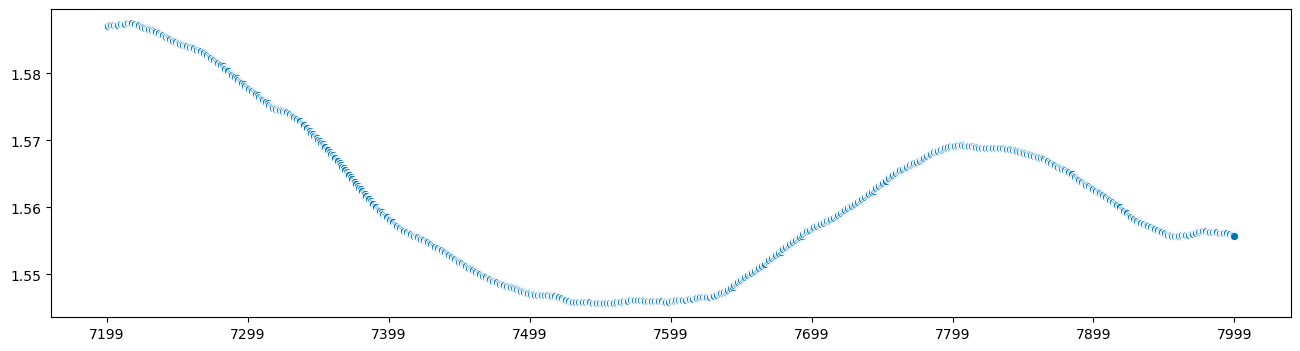

In [14]:
y = df[['SMA']]
from sktime.utils.plotting import plot_series
plot_series(y)

## Forecasting with Linear Regression

In [17]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(y, test_size=24*5) # Predict from 1st July 2019

MAPE: 0.000932


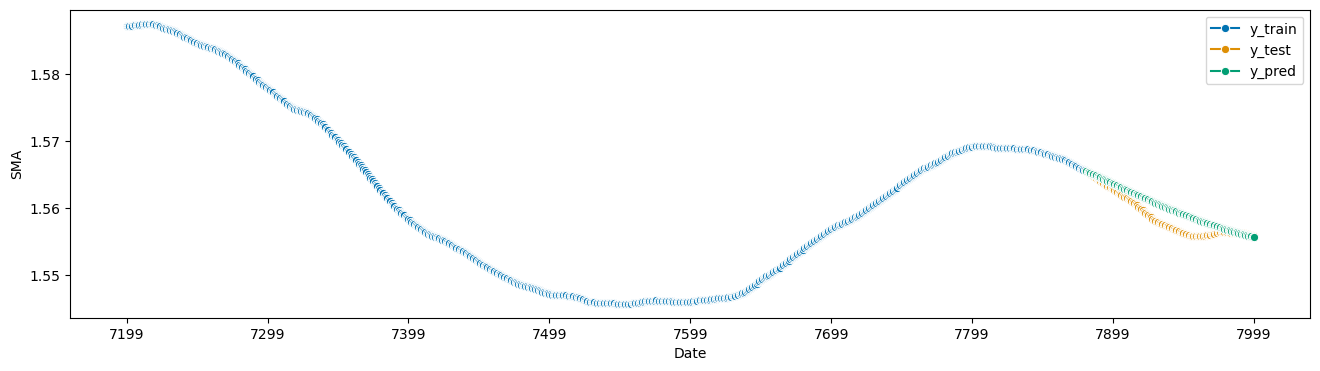

In [18]:
from sktime.forecasting.base import ForecastingHorizon
from sklearn.linear_model import LinearRegression, LassoCV
from sktime.forecasting.compose import make_reduction
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=20, strategy="recursive")
forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')

print('MAPE: %.6f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

4.280868532593999

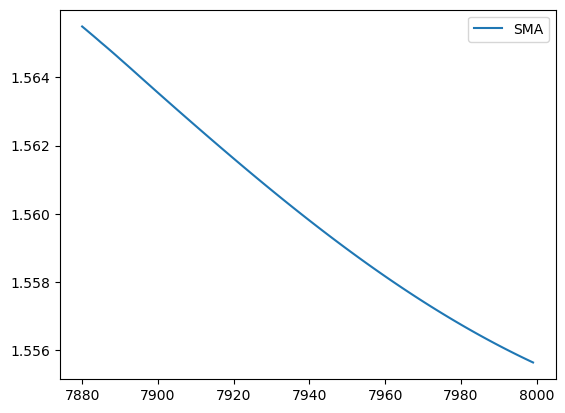

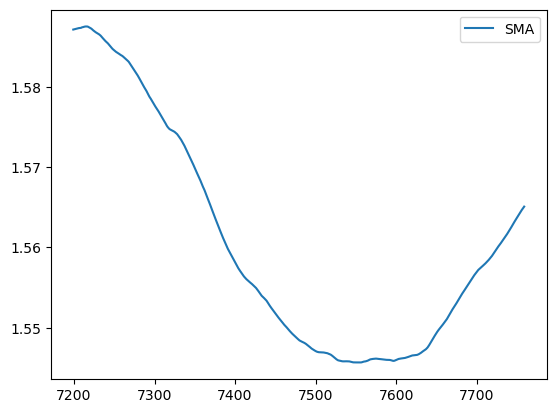

In [21]:
scale = 1e-05
y_pred_len = len(y_pred)
y_pred_dff = np.diff(y_pred.values.flatten())
# y_pred_grad is the sum of y_pred_dff divided by the length of y_pred_dff
y_pred_grad = sum(y_pred_dff)/(y_pred_len * scale)
y_pred.plot(label="y_pred")


# sub_y_test is the last 24 values of y_test
# sub_y_train = y_train.iloc[120:240]
sub_y_train = y_train.iloc[:-120]
# plot sub_y_train
sub_y_train.plot()

# sub_y_train = y_train
sub_y_train_len = len(sub_y_train)
sub_y_train_dff = np.diff(sub_y_train.values.flatten())
sub_y_train_grad = sum(sub_y_train_dff)/(sub_y_train_len * scale)

# print('MAPE: %.6f' % mean_absolute_percentage_error(y_test_dff, y_pred_dff, symmetric=False))
error = sub_y_train_grad - y_pred_grad
error

In [22]:
y_pred_new_grad = np.gradient(y_pred.values.flatten())
y_pred_new_grad_sum = sum(y_pred_new_grad)
print(y_pred_new_grad_sum)

sub_y_train_new_grad = np.gradient(sub_y_train.values.flatten())
sub_y_train_new_grad_sum = sum(sub_y_train_new_grad)
print(sub_y_train_new_grad_sum)

error = y_pred_new_grad_sum - sub_y_train_new_grad_sum
print(error)

-0.009924831804349998
-0.021960249999999126
0.012035418195649128


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define a numpy array of y values
# y = np.array([20, 4.2, 6.1, 8.3, 18.2])

# Define a numpy array of x values
x = np.arange(1, len(y)+1)
# x = np.array([1, 2, 3, 4, 5])

# Use numpy.polyfit to fit a straight line of degree 1 to the data and get the slope and intercept
slope, intercept = np.polyfit(x, y, 1)

# Print the slope and intercept
print(f"The slope of the line is {slope}")
print(f"The intercept of the line is {intercept}")

# Use numpy.polyval to get the fitted y values for the x values
y_fit = np.polyval([slope, intercept], x)

# Print the fitted y values
print(f"The fitted y values are {y_fit}")

# Calculate the mean squared error between the actual y values and the fitted y values
mse = np.mean((y - y_fit) ** 2)

# Print the mean squared error
print(f"The mean squared error is {mse}")

# Create a figure and an axis object using matplotlib.pyplot.subplots
fig, ax = plt.subplots()

# Plot the actual data points as blue circles using ax.scatter
ax.scatter(x, y, color="blue", label="Actual data")

# Plot the fitted line as a red dashed line using ax.plot
ax.plot(x, y_fit, color="red", linestyle="--", label="Fitted line")

# Set the title, xlabel, ylabel and legend using ax.set_title, ax.set_xlabel, ax.set_ylabel and ax.legend
ax.set_title("Linear regression using numpy.polyfit")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
 
# Show the figure using plt.show
plt.show()


The slope of the line is [-1.91076407e-05]
The intercept of the line is [1.56890252]
The fitted y values are [1.56888341 1.5688643  1.56884519 1.56882608 1.56880698 1.56878787
 1.56876876 1.56874965 1.56873055 1.56871144 1.56869233 1.56867322
 1.56865412 1.56863501 1.5686159  1.56859679 1.56857769 1.56855858
 1.56853947 1.56852036 1.56850125 1.56848215 1.56846304 1.56844393
 1.56842482 1.56840572 1.56838661 1.5683675  1.56834839 1.56832929
 1.56831018 1.56829107 1.56827196 1.56825286 1.56823375 1.56821464
 1.56819553 1.56817643 1.56815732 1.56813821 1.5681191  1.56809999
 1.56808089 1.56806178 1.56804267 1.56802356 1.56800446 1.56798535
 1.56796624 1.56794713 1.56792803 1.56790892 1.56788981 1.5678707
 1.5678516  1.56783249 1.56781338 1.56779427 1.56777516 1.56775606
 1.56773695 1.56771784 1.56769873 1.56767963 1.56766052 1.56764141
 1.5676223  1.5676032  1.56758409 1.56756498 1.56754587 1.56752677
 1.56750766 1.56748855 1.56746944 1.56745033 1.56743123 1.56741212
 1.56739301 1.5673739

ValueError: Unable to coerce to Series, length must be 1: given 801

In [23]:
# Import libraries
import numpy as np
import scipy.signal as signal

# Define two signals
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])

# Calculate cross-correlation
z = signal.correlate(x, y, mode='full', method='auto')

# Print result
print(z)


[ 10  28  52  80 110  80  52  28  10]


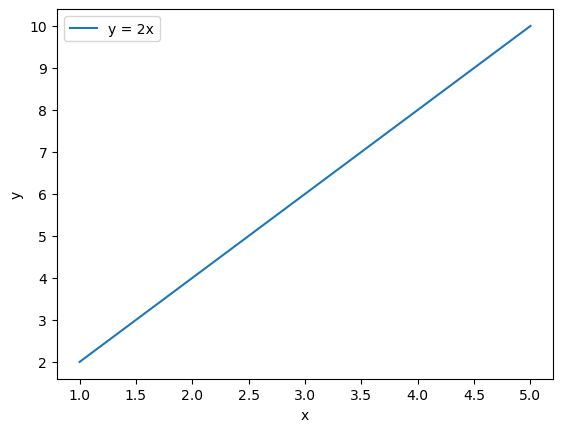

In [25]:
# Import library
import matplotlib.pyplot as plt

# Define x and y arrays
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])

# Plot x and y
plt.plot(x, y, label='y = 2x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

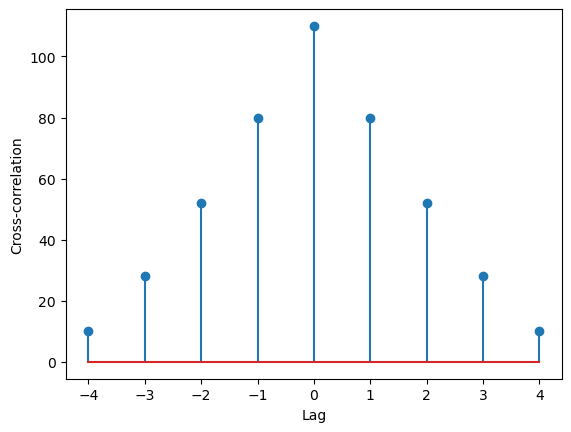

In [24]:
# Import library
import matplotlib.pyplot as plt

# Define lag array
lags = np.arange(-4, 5)

# Plot cross-correlation
plt.stem(lags, z)
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()


In [19]:
# Import the modules
import numpy as np
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.trend import PolynomialTrendForecaster
import matplotlib.pyplot as plt

# Load the data
# y = load_airline()

# Split the data into train and test sets
y_train, y_test = temporal_train_test_split(y, test_size=24*5)

# Define the trend forecaster with degree 1 (linear)
trend_forecaster = PolynomialTrendForecaster(degree=1)

# Fit the trend forecaster to the train set and predict on both sets
trend_forecaster.fit(y_train)
y_train_trend = trend_forecaster.predict(fh=y_train.index)
y_test_trend = trend_forecaster.predict(fh=y_test.index)

print(y_train_trend)
print(y_test_trend)


array([-4.76739989e-06, -3.16658903e-06, -4.90016227e-06, -6.30146666e-06,
       -6.50506635e-06, -4.76474090e-06, -3.66409031e-06, -1.86534430e-06,
       -3.69548550e-07,  1.83542700e-06,  3.30714476e-06,  4.58280845e-06,
        5.26781278e-06,  6.38182458e-06,  7.04395474e-06,  8.03133270e-06,
        8.85144494e-06,  9.88034383e-06,  1.06633780e-05,  1.17745991e-05,
        1.27873593e-05,  1.37260678e-05,  1.43996712e-05,  1.51578074e-05,
        1.57911567e-05,  1.64670758e-05,  1.69929100e-05,  1.75907364e-05,
        1.81309917e-05,  1.87349571e-05,  1.92581978e-05,  1.97950036e-05,
        2.02446938e-05,  2.06901577e-05,  2.10866103e-05,  2.14959703e-05,
        2.18385528e-05,  2.21783153e-05,  2.24903185e-05,  2.28179064e-05,
        2.31070665e-05,  2.33913608e-05,  2.36433347e-05,  2.38945857e-05,
        2.41194254e-05,  2.43384241e-05,  2.45316300e-05,  2.47187998e-05,
        2.48874089e-05,  2.50544022e-05,  2.52058545e-05,  2.53507913e-05,
        2.54795495e-05,  

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"], x_label='Date', y_label='SMA')
print('MAPE: %.4f' % mean_absolute_percentage_error(y_test, y_pred, symmetric=False))

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

### XGBoost with multiple inputs

### Tuning the hyperparameters of our forecaster

In [ ]:
from sktime.forecasting.model_selection import SingleWindowSplitter, ForecastingRandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=1)
forecaster = make_reduction(regressor, window_length=52, strategy="recursive")
gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions= {
                                        'deseasonalize__model': ['multiplicative', 'additive'],
                                        'detrend__forecaster__degree': [1, 2, 3],
                                        'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
                                        'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
                                        'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                                        'forecast__estimator__n_estimators': [100, 500, 1000],
                                    }, 
                                     n_iter=1_00, 
                                     random_state=1)

forecaster.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

In [ ]:
gscv.cv_results_

## Adding components to our forecasting pipeline

In [ ]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import SingleWindowSplitter, SlidingWindowSplitter
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV

regressor = XGBRegressor(objective='reg:squarederror', random_state=1)

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=52, strategy="recursive")),
    ]
)

param_grid = {
    'deseasonalize__model': ['multiplicative', 'additive'],
    'detrend__forecaster__degree': [1, 2, 3],
    'forecast__estimator__max_depth': [3, 5, 6, 10, 15, 20],
    'forecast__estimator__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'forecast__estimator__subsample': np.arange(0.5, 1.0, 0.1),
    'forecast__estimator__colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'forecast__estimator__n_estimators': [100, 500, 1000]
}

gscv = ForecastingRandomizedSearchCV(forecaster, 
                                     cv=SlidingWindowSplitter(window_length=len(y_train)-26, fh=26), param_distributions=param_grid, 
                                     n_iter=1_00, 
                                     random_state=1)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
gscv.cv_results_

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

# declarative forecaster specification - just two lines!
regressor = KNeighborsRegressor(n_neighbors=4)
forecaster = make_reduction(regressor, window_length=55, strategy="recursive")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)


In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.fbprophet import Prophet
# Prophet requires to have data with a pandas.DatetimeIndex
forecaster = Prophet(  
    seasonality_mode='multiplicative',
    # n_changepoints=int(len(y) / 12),
    )
# forecaster.fit(y_train)  

# y_pred = forecaster.predict(fh=[1,2,3])  